In [210]:
%matplotlib inline
import glob
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [211]:
filenames = glob.glob("data/features/*.csv")
converters={"failure": str}
dfs= [pd.read_csv(filename, converters=converters) for filename in filenames]
combined_df = pd.concat(dfs, ignore_index=True)
combined_df.set_index(['timestamp', 'machineID'], inplace=True)

In [212]:
combined_df.head()

,,cycle,speed_avg,temperature_avg,temperature_max,pressure_avg,rolling_average,failure,rul
timestamp,machineID,,,,,,,,
2018-05-13T13:12:00.000-07:00,M_0011,269,999.872917,147.307542,147.54,1008.014750,146.921667,,NaN
2018-05-12T17:18:00.000-07:00,M_0011,268,1000.050542,147.043208,147.25,1015.708583,146.703333,,NaN
2018-05-12T01:53:00.000-07:00,M_0011,267,999.564222,146.803778,147.00,1020.744500,146.490000,,NaN
2018-05-11T02:25:00.000-07:00,M_0011,266,1000.016500,146.608556,146.79,1024.951333,146.306667,,NaN
2018-05-10T15:55:00.000-07:00,M_0011,265,999.836667,146.400917,146.60,1032.106458,146.113333,,NaN


In [213]:
seed = 42
w = 8

clf = RandomForestClassifier(random_state=seed)

combined_df.sort_index(inplace=True)
X = combined_df.reset_index(drop = True).drop(['cycle', 'failure', 'rul'], axis=1)
Y = combined_df.apply(lambda row: row.failure if row.rul and row.rul < w else '', axis=1)

# tscv = TimeSeriesSplit(n_splits=6)
# cross_val_score(clf, X, Y, cv=tscv)

# for train_index, test_index in tscv.split(X):
#     train = X[[train_index]]
#     test = X[[test_index]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
sm = SMOTE(random_state=seed)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)

clf.fit(X_train_res, Y_train_res)

c = Counter(Y_test)
c

Counter({'': 54543, 'F1': 2965})

array([[53836,   707],
       [   83,  2882]])

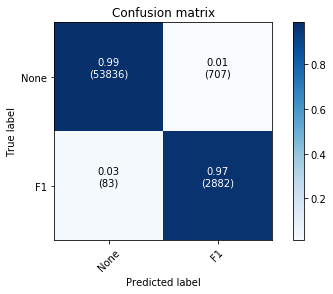

In [214]:
Y_predictions = clf.predict(X_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        orig = cm
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt) + '\n({0})'.format(orig[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(Y_test, Y_predictions)
plot_confusion_matrix(cm, ['None', 'F1'], normalize=True)
cm

In [215]:
accuracy_score(Y_test, Y_predictions)

0.9862627808304931

In [216]:
Y_test.where(Y_test != 'F1').count()

54543